# **Pykan Installation**

In [ ]:
%pip install pykan
%pip install torchprofile

# **KANs on Univariate Data**

## 1. Number Squares

### Training

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.78e+00 | test_loss: 5.78e+00 | reg: 1.28e+01 | :   0%| | 2/500 [00:00<00:35, 13.92it

| train_loss: 5.49e+00 | test_loss: 5.49e+00 | reg: 4.32e+01 | : 100%|█| 500/500 [00:11<00:00, 41.83


saving model version 0.1
Learned symbolic formula: 0


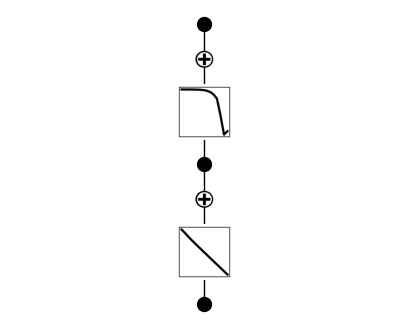

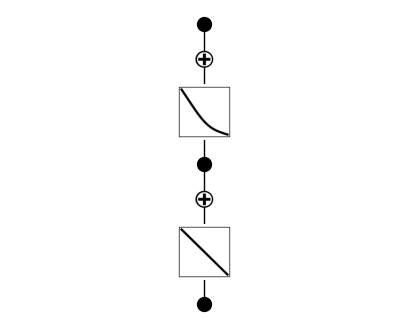

In [28]:
import pandas as pd
import torch
from kan import KAN
from kan.utils import create_dataset, ex_round

df = pd.read_csv('datasets/numsquares.csv')
x = torch.tensor(df[['number']].values, dtype=torch.float32)
y = torch.tensor(df[['square']].values, dtype=torch.float32)


dataset = {
    'train_input': x,
    'train_label': y,
    'test_input': x,  
    'test_label': y
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = KAN(width=[1, 1, 1], grid=1, k=1, seed=0, device=device)

model(dataset['train_input'])
model.plot()

model.fit(dataset, opt="LBFGS", steps=500, lamb=0.001)

model.plot()

symbolic_formula = ex_round(model.symbolic_formula()[0][0], 4)
print("Learned symbolic formula:", symbolic_formula)


### Inference

In [29]:
def predict_square(number):
    input_tensor = torch.tensor([[number]], dtype=torch.float32).to(device)

    with torch.no_grad():  
        output_tensor = model(input_tensor)

    predicted_square = output_tensor.item()
    print(f"The predicted square of {number} is approximately {predicted_square}")
    return predicted_square


predict_square(int(input("Input Number:")))

The predicted square of 8 is approximately 63.323089599609375


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/kan/MultKAN.py:798: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/kan/MultKAN.py:808: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/kan/MultKAN.py:809: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/nati

63.323089599609375

#### Inference FLOPS

In [30]:
import torch
from kan import KAN
import torchprofile

# Set up the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define and initialize the KAN model
model = KAN(width=[1, 1, 1], grid=1, k=1, seed=0, device=device)
model.to(device)
model.eval()  # Set the model to evaluation mode

# Prepare a sample input tensor
input_tensor = torch.tensor([[2]], dtype=torch.float32).to(device)  # Single input value

# Calculate FLOPs using torchprofile
with torch.no_grad():
    flops = torchprofile.profile_macs(model, input_tensor)  # Get MACs as an estimate for FLOPs

print(f"Estimated FLOPs for one forward pass: {flops}")


checkpoint directory created: ./model
saving model version 0.0
Estimated FLOPs for one forward pass: 32


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::silu". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::unsqueeze". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::ge". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::nan_to_num". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::einsum". Skipped.

In [31]:
import torch
import torch.nn as nn
import torchprofile

# Set up the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define a simple MLP with the same structure as the KAN model: [1, 1, 1]
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(1, 1)
        self.fc2 = nn.Linear(1, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize and set the model to the specified device and evaluation mode
model = SimpleMLP().to(device)
model.eval()

# Prepare a sample input tensor
input_tensor = torch.tensor([[2]], dtype=torch.float32).to(device)  # Single input value

# Calculate FLOPs using torchprofile
with torch.no_grad():
    flops = torchprofile.profile_macs(model, input_tensor)  # Get MACs as an estimate for FLOPs

print(f"Estimated FLOPs for one forward pass: {flops}")


Estimated FLOPs for one forward pass: 2


## 2. Univariate Time Series (Daily Minimum Temperature)

### **Implementation with KAN**

#### Training

In [9]:
import numpy as np
import pandas as pd
import torch
import kan

DATASET_DATE_COLUMN = 'Date'
time_series_data = pd.read_csv('datasets/dailymintemp.csv', parse_dates=[DATASET_DATE_COLUMN])
time_series_data["month normalized"] = time_series_data[DATASET_DATE_COLUMN].dt.month / 12
time_series_data["day normalized"] = time_series_data[DATASET_DATE_COLUMN].dt.day / time_series_data[DATASET_DATE_COLUMN].dt.days_in_month
time_series_data["Daily minimum temperatures"] = pd.to_numeric(time_series_data["Daily minimum temperatures"], errors='coerce')
time_series_data = time_series_data[time_series_data["Daily minimum temperatures"].notnull()]

WINDOW_LEN = 3
TRAIN_TEST_RATIO = 0.2
LABEL_COLUMN = "Daily minimum temperatures"
BASE_INPUT_COLUMNS = ["month normalized", "day normalized"]

selected_data = time_series_data[BASE_INPUT_COLUMNS + [LABEL_COLUMN]].copy()
window_columns = []
for i in range(WINDOW_LEN):
    window_col_name = f'old val -{i+1}'
    window_columns.append(window_col_name)
    selected_data[window_col_name] = selected_data[LABEL_COLUMN].shift(i+1)

selected_data = selected_data[WINDOW_LEN:]
train_size = int(len(selected_data) * (1 - TRAIN_TEST_RATIO))
train_raw, test_raw = selected_data[:train_size], selected_data[train_size:]

train_labels = torch.tensor(train_raw[LABEL_COLUMN].values, dtype=torch.float32).unsqueeze(-1)
test_labels = torch.tensor(test_raw[LABEL_COLUMN].values, dtype=torch.float32).unsqueeze(-1)

norm_max = train_labels.max()
train_labels /= norm_max
test_labels /= norm_max
for window_column in window_columns:
    selected_data[window_column] /= norm_max.item()

input_columns = BASE_INPUT_COLUMNS + window_columns
train_input = torch.tensor(np.array([train_raw[in_col].values for in_col in input_columns]), dtype=torch.float32).transpose(0, 1)
test_input = torch.tensor(np.array([test_raw[in_col].values for in_col in input_columns]), dtype=torch.float32).transpose(0, 1)

model = kan.KAN(width=[len(input_columns), 3, 3, 1], grid=10, k=3, seed=0)
model.fit({'train_input': train_input, 'train_label': train_labels, 'test_input': test_input, 'test_label': test_labels}, opt="LBFGS", steps=100)

torch.save(model.state_dict(), 'trained_kan_model.pth')



checkpoint directory created: ./model
saving model version 0.0


description:   0%|                                                          | 0/100 [00:00<?, ?it/s]

| train_loss: 7.50e-02 | test_loss: 1.02e-01 | reg: 1.63e+01 | : 100%|█| 100/100 [00:38<00:00,  2.57

saving model version 0.1


#### Date Normalization

In [1]:
import pandas as pd
import numpy as np

data = {
    "Date": pd.date_range(start="2022-01-01", periods=10, freq="D"),
    "Daily minimum temperatures": [20.0, 18.5, 19.0, 21.5, 20.0, 17.5, 18.0, 20.5, 22.0, 19.5]
}
time_series_data = pd.DataFrame(data)

time_series_data["month normalized"] = time_series_data["Date"].dt.month / 12
time_series_data["day normalized"] = time_series_data["Date"].dt.day / time_series_data["Date"].dt.days_in_month

window_len = 3
for i in range(1, window_len + 1):
    time_series_data[f"old val -{i}"] = time_series_data["Daily minimum temperatures"].shift(i)

def get_normalized_array(date, df):
    row = df[df["Date"] == date].iloc[0]

    norm_max = df["Daily minimum temperatures"].max()

    normalized_array = [
        row["month normalized"],
        row["day normalized"],
        row[f"old val -1"] / norm_max if pd.notna(row[f"old val -1"]) else None,
        row[f"old val -2"] / norm_max if pd.notna(row[f"old val -2"]) else None,
        row[f"old val -3"] / norm_max if pd.notna(row[f"old val -3"]) else None
    ]
    
    return normalized_array

date_input = pd.Timestamp("2022-01-05")
normalized_array = get_normalized_array(date_input, time_series_data)
print("Normalized Array:", normalized_array)


Normalized Array: [0.08333333333333333, 0.16129032258064516, 0.9772727272727273, 0.8636363636363636, 0.8409090909090909]


#### Inference

In [10]:
import torch
import kan

model = kan.KAN(width=[5, 3, 3, 1], grid=10, k=3, seed=0)  # Adjust `width` based on the input configuration during training

model.load_state_dict(torch.load('trained_kan_model.pth'))

model.eval()

def predict_daily_min_temp(input_data, norm_max):
    input_tensor = torch.tensor([input_data], dtype=torch.float32)
    
    with torch.no_grad():
        output_tensor = model(input_tensor)
    
    predicted_temp = output_tensor.item() * norm_max
    return predicted_temp

sample_input = [0.5, 0.15, 0.7, 0.65, 0.6]  
norm_max = 20.0  

predicted_temp = predict_daily_min_temp(sample_input, norm_max)
print(f"Predicted Daily Minimum Temperature: {predicted_temp:.2f}")


checkpoint directory created: ./model
saving model version 0.0
Predicted Daily Minimum Temperature: 8.81


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/kan/MultKAN.py:798: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/kan/MultKAN.py:808: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/kan/MultKAN.py:809: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/nati

#### Accuracy Check

In [28]:
import numpy as np
import pandas as pd
import torch
import kan
from sklearn.metrics import mean_absolute_error, mean_squared_error

DATASET_DATE_COLUMN = 'Date'
data_file = 'datasets/dailymintemp.csv'
time_series_data = pd.read_csv(data_file, parse_dates=[DATASET_DATE_COLUMN])
time_series_data["month normalized"] = time_series_data[DATASET_DATE_COLUMN].dt.month / 12
time_series_data["day normalized"] = time_series_data[DATASET_DATE_COLUMN].dt.day / time_series_data[DATASET_DATE_COLUMN].dt.days_in_month
time_series_data["Daily minimum temperatures"] = pd.to_numeric(time_series_data["Daily minimum temperatures"], errors='coerce')
time_series_data = time_series_data[time_series_data["Daily minimum temperatures"].notnull()]

WINDOW_LEN = 3
TRAIN_TEST_RATIO = 0.2
LABEL_COLUMN = "Daily minimum temperatures"
BASE_INPUT_COLUMNS = ["month normalized", "day normalized"]

selected_data = time_series_data[BASE_INPUT_COLUMNS + [LABEL_COLUMN]].copy()
window_columns = []
for i in range(WINDOW_LEN):
    window_col_name = f'old val -{i+1}'
    window_columns.append(window_col_name)
    selected_data[window_col_name] = selected_data[LABEL_COLUMN].shift(i+1)

selected_data = selected_data[WINDOW_LEN:]
train_size = int(len(selected_data) * (1 - TRAIN_TEST_RATIO))
train_raw, test_raw = selected_data[:train_size], selected_data[train_size:]

test_labels = torch.tensor(test_raw[LABEL_COLUMN].values, dtype=torch.float32).unsqueeze(-1)
norm_max = test_labels.max()
test_labels /= norm_max
test_input = torch.tensor(np.array([test_raw[col].values for col in BASE_INPUT_COLUMNS + window_columns]), dtype=torch.float32).transpose(0, 1)

model = kan.KAN(width=[len(BASE_INPUT_COLUMNS + window_columns), 3, 3, 1], grid=10, k=3, seed=0)
model.load_state_dict(torch.load('trained_kan_model.pth'))
model.eval() 

with torch.no_grad():
    predictions = model(test_input) * norm_max  
    test_labels = test_labels * norm_max  

predictions = predictions.numpy().squeeze()
test_labels = test_labels.numpy().squeeze()

mae = mean_absolute_error(test_labels, predictions)
rmse = mean_squared_error(test_labels, predictions, squared=False)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


checkpoint directory created: ./model
saving model version 0.0
Mean Absolute Error (MAE): 53.3042
Root Mean Squared Error (RMSE): 56.3500


#### Inference FLOPS

In [13]:
def calculate_kan_inference_flops(width):
    total_flops = 0
    for i in range(len(width) - 1):
        input_size = width[i]
        output_size = width[i + 1]
        layer_flops = 2 * input_size * output_size  
        total_flops += layer_flops
    return total_flops

kan_width = [5, 3, 3, 1]  
inference_flops = calculate_kan_inference_flops(kan_width)
print(f"Estimated FLOPs for KAN model inference: {inference_flops}")


Estimated FLOPs for KAN model inference: 54


### **Implementation with MLP**

#### Training 

In [29]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

DATASET_DATE_COLUMN = 'Date'
time_series_data = pd.read_csv('datasets/dailymintemp.csv', parse_dates=[DATASET_DATE_COLUMN])
time_series_data["month normalized"] = time_series_data[DATASET_DATE_COLUMN].dt.month / 12
time_series_data["day normalized"] = time_series_data[DATASET_DATE_COLUMN].dt.day / time_series_data[DATASET_DATE_COLUMN].dt.days_in_month
time_series_data["Daily minimum temperatures"] = pd.to_numeric(time_series_data["Daily minimum temperatures"], errors='coerce')
time_series_data = time_series_data[time_series_data["Daily minimum temperatures"].notnull()]

WINDOW_LEN = 3
TRAIN_TEST_RATIO = 0.2
LABEL_COLUMN = "Daily minimum temperatures"
BASE_INPUT_COLUMNS = ["month normalized", "day normalized"]

selected_data = time_series_data[BASE_INPUT_COLUMNS + [LABEL_COLUMN]].copy()
window_columns = []
for i in range(WINDOW_LEN):
    window_col_name = f'old val -{i+1}'
    window_columns.append(window_col_name)
    selected_data[window_col_name] = selected_data[LABEL_COLUMN].shift(i+1)

selected_data = selected_data[WINDOW_LEN:]
train_size = int(len(selected_data) * (1 - TRAIN_TEST_RATIO))
train_raw, test_raw = selected_data[:train_size], selected_data[train_size:]

train_labels = torch.tensor(train_raw[LABEL_COLUMN].values, dtype=torch.float32).unsqueeze(-1)
test_labels = torch.tensor(test_raw[LABEL_COLUMN].values, dtype=torch.float32).unsqueeze(-1)

norm_max = train_labels.max()
train_labels /= norm_max
test_labels /= norm_max
for window_column in window_columns:
    selected_data[window_column] /= norm_max.item()

input_columns = BASE_INPUT_COLUMNS + window_columns
train_input = torch.tensor(np.array([train_raw[col].values for col in input_columns]), dtype=torch.float32).transpose(0, 1)
test_input = torch.tensor(np.array([test_raw[col].values for col in input_columns]), dtype=torch.float32).transpose(0, 1)

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(input_size, 3)
        self.hidden2 = nn.Linear(3, 3)
        self.output = nn.Linear(3, 1)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = self.output(x)
        return x

model = MLP(input_size=len(input_columns))
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
for epoch in range(num_epochs):

    outputs = model(train_input)
    loss = criterion(outputs, train_labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

torch.save(model.state_dict(), 'trained_mlp_univariate_model.pth')
print("Training completed and model saved as 'trained_mlp_univariate_model.pth'")


Epoch [10/100], Loss: 0.0219
Epoch [20/100], Loss: 0.0208
Epoch [30/100], Loss: 0.0202
Epoch [40/100], Loss: 0.0195
Epoch [50/100], Loss: 0.0186
Epoch [60/100], Loss: 0.0176
Epoch [70/100], Loss: 0.0165
Epoch [80/100], Loss: 0.0154
Epoch [90/100], Loss: 0.0145
Epoch [100/100], Loss: 0.0137
Training completed and model saved as 'trained_mlp_univariate_model.pth'


#### Inference

In [ ]:
import numpy as np
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(input_size, 3)
        self.hidden2 = nn.Linear(3, 3)
        self.output = nn.Linear(3, 1)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = self.output(x)
        return x

input_size = 5  
model = MLP(input_size=input_size)
model.load_state_dict(torch.load('trained_mlp_univariate_model.pth'))
model.eval()  
def make_prediction(month_norm, day_norm, old_val1, old_val2, old_val3, norm_max):
    input_tensor = torch.tensor([[month_norm, day_norm, old_val1, old_val2, old_val3]], dtype=torch.float32)
    
    with torch.no_grad():
        prediction = model(input_tensor) * norm_max 
    return prediction.item()

print("Enter normalized values for prediction:")
month_norm = float(input("Month normalized (0-1): "))
day_norm = float(input("Day normalized (0-1): "))
old_val1 = float(input("Previous temperature (normalized): "))
old_val2 = float(input("Temperature 2 days ago (normalized): "))
old_val3 = float(input("Temperature 3 days ago (normalized): "))

norm_max = 20.0  

predicted_temp = make_prediction(month_norm, day_norm, old_val1, old_val2, old_val3, norm_max)
print(f"Predicted Daily Minimum Temperature: {predicted_temp:.2f}")


#### Accuracy Check (MLP)

In [30]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import mean_absolute_error, mean_squared_error

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(input_size, 3)
        self.hidden2 = nn.Linear(3, 3)
        self.output = nn.Linear(3, 1)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = self.output(x)
        return x

DATASET_DATE_COLUMN = 'Date'
data_file = 'datasets/dailymintemp.csv'
time_series_data = pd.read_csv(data_file, parse_dates=[DATASET_DATE_COLUMN])
time_series_data["month normalized"] = time_series_data[DATASET_DATE_COLUMN].dt.month / 12
time_series_data["day normalized"] = time_series_data[DATASET_DATE_COLUMN].dt.day / time_series_data[DATASET_DATE_COLUMN].dt.days_in_month
time_series_data["Daily minimum temperatures"] = pd.to_numeric(time_series_data["Daily minimum temperatures"], errors='coerce')
time_series_data = time_series_data[time_series_data["Daily minimum temperatures"].notnull()]

WINDOW_LEN = 3
TRAIN_TEST_RATIO = 0.2
LABEL_COLUMN = "Daily minimum temperatures"
BASE_INPUT_COLUMNS = ["month normalized", "day normalized"]

selected_data = time_series_data[BASE_INPUT_COLUMNS + [LABEL_COLUMN]].copy()
window_columns = []
for i in range(WINDOW_LEN):
    window_col_name = f'old val -{i+1}'
    window_columns.append(window_col_name)
    selected_data[window_col_name] = selected_data[LABEL_COLUMN].shift(i+1)

selected_data = selected_data[WINDOW_LEN:]
train_size = int(len(selected_data) * (1 - TRAIN_TEST_RATIO))
train_raw, test_raw = selected_data[:train_size], selected_data[train_size:]

test_labels = torch.tensor(test_raw[LABEL_COLUMN].values, dtype=torch.float32).unsqueeze(-1)
norm_max = test_labels.max()
test_labels /= norm_max
test_input = torch.tensor(np.array([test_raw[col].values for col in BASE_INPUT_COLUMNS + window_columns]), dtype=torch.float32).transpose(0, 1)

model = MLP(input_size=len(BASE_INPUT_COLUMNS + window_columns))
model.load_state_dict(torch.load('trained_mlp_univariate_model.pth'))
model.eval() 

with torch.no_grad():
    predictions = model(test_input) * norm_max  
    test_labels = test_labels * norm_max  

predictions = predictions.numpy().squeeze()
test_labels = test_labels.numpy().squeeze()

# Calculate accuracy metrics
mae = mean_absolute_error(test_labels, predictions)
rmse = mean_squared_error(test_labels, predictions, squared=False)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


Mean Absolute Error (MAE): 92.0017
Root Mean Squared Error (RMSE): 96.5915


#### Inference FLOPS

In [11]:
import numpy as np
import torch
import torch.nn as nn
from ptflops import get_model_complexity_info

# Define the MLP model class (same as in training and inference)
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(input_size, 3)
        self.hidden2 = nn.Linear(3, 3)
        self.output = nn.Linear(3, 1)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = self.output(x)
        return x

# Load the trained model
input_size = 5  # Adjust according to the input dimensions (month norm, day norm, and 3 previous values)
model = MLP(input_size=input_size)
model.load_state_dict(torch.load('trained_mlp_univariate_model.pth'))
model.eval()  # Set model to evaluation mode

# Use ptflops to calculate FLOPs for a single forward pass (inference)
with torch.no_grad():
    flops, params = get_model_complexity_info(model, (input_size,), as_strings=True, print_per_layer_stat=True)
    print(f"Estimated FLOPs for inference with MLP model: {flops}")
    print(f"Total parameters in the model: {params}")


MLP(
  34, 100.000% Params, 34.0 Mac, 100.000% MACs, 
  (hidden1): Linear(18, 52.941% Params, 18.0 Mac, 52.941% MACs, in_features=5, out_features=3, bias=True)
  (hidden2): Linear(12, 35.294% Params, 12.0 Mac, 35.294% MACs, in_features=3, out_features=3, bias=True)
  (output): Linear(4, 11.765% Params, 4.0 Mac, 11.765% MACs, in_features=3, out_features=1, bias=True)
)
Estimated FLOPs for inference with MLP model: 34 Mac
Total parameters in the model: 34


# **KAN on Multivariate Data**

## Smart Irrigation System (small)

### Training

In [5]:
# Imports
import numpy as np
import pandas as pd
import torch
import kan

# Load and preprocess the dataset
DATASET_FILE = 'datasets/irrigation1.csv'
data = pd.read_csv(DATASET_FILE)

# Select input features and target variable
FEATURES = ["moisture", "temp"]
TARGET = "pump"

# Split the data into inputs and target
X = data[FEATURES].values
y = data[TARGET].values

# Convert to torch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)  # Convert target to tensor with float32

# Split into train and test sets
TRAIN_TEST_RATIO = 0.8
train_size = int(len(X_tensor) * TRAIN_TEST_RATIO)
train_X, test_X = X_tensor[:train_size], X_tensor[train_size:]
train_y, test_y = y_tensor[:train_size], y_tensor[train_size:]

# Define the model
model = kan.KAN(width=[2, 3, 3, 1], grid=5, k=3, seed=0)

# Train the model
model.fit({'train_input': train_X, 'train_label': train_y, 'test_input': test_X, 'test_label': test_y},
          opt="LBFGS", steps=100)

# Save the model's state dictionary
torch.save(model.state_dict(), 'trained_irrigation_model1.pth')
print("Training completed and model saved as 'trained_irrigation_model1.pth'")


checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.37e-01 | test_loss: 4.64e-02 | reg: 0.00e+00 | :   3%| | 3/100 [00:00<00:09, 10.02it

| train_loss: 9.87e-02 | test_loss: 4.56e-02 | reg: 1.46e+01 | : 100%|█| 100/100 [00:07<00:00, 14.01

saving model version 0.1
Training completed and model saved as 'trained_irrigation_model1.pth'


### Inference

In [4]:
# Imports
import torch
import kan

# Load the model architecture and state dictionary
model = kan.KAN(width=[2, 3, 3, 1], grid=5, k=3, seed=0)
model.load_state_dict(torch.load('trained_irrigation_model1.pth'))
model.eval()  # Set model to evaluation mode

# Define a function for prediction
def predict_pump(moisture, temp):
    # Convert input to tensor
    input_tensor = torch.tensor([[moisture, temp]], dtype=torch.float32)
    
    # Perform inference
    with torch.no_grad():
        output = model(input_tensor)
    
    # Interpret output as ON or OFF
    pump_status = "OFF" if output.item() >= 0.5 else "ON"
    return pump_status

# Request user input
try:
    moisture = float(input("Enter soil moisture level: "))
    temp = float(input("Enter temperature: "))
    result = predict_pump(moisture, temp)
    print(f"The pump should be: {result}")
except ValueError:
    print("Please enter valid numerical values for moisture and temperature.")


checkpoint directory created: ./model
saving model version 0.0


## Smart Irrigation System (Large)

### **Implementing using KAN**

#### Training 

In [19]:
# Imports
import numpy as np
import pandas as pd
import torch
import kan

# Load and preprocess the dataset
DATASET_FILE = 'datasets/irrigation2.csv'
data = pd.read_csv(DATASET_FILE)

# Select input features and target variable
FEATURES = ["Soil Moisture", "Temperature", "Air temperature (C)", "rainfall", "Air humidity (%)", "Wind speed (Km/h)", "Wind gust (Km/h)", " Soil Humidity"]
TARGET = "Status"

# Convert target variable to binary: ON = 1, OFF = 0
data[TARGET] = data[TARGET].apply(lambda x: 1 if x == "ON" else 0)

# Extract features and target
X = data[FEATURES].values
y = data[TARGET].values

# Convert to torch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)  # Convert target to tensor with float32

# Split into train and test sets
TRAIN_TEST_RATIO = 0.8
train_size = int(len(X_tensor) * TRAIN_TEST_RATIO)
train_X, test_X = X_tensor[:train_size], X_tensor[train_size:]
train_y, test_y = y_tensor[:train_size], y_tensor[train_size:]

# Define the model
model = kan.KAN(width=[len(FEATURES), 4, 4, 1], grid=5, k=3, seed=42)

# Train the model
model.fit({'train_input': train_X, 'train_label': train_y, 'test_input': test_X, 'test_label': test_y},
          opt="Adam", steps=1000)

# Save the model's state dictionary
torch.save(model.state_dict(), 'trained_irrigation_model2.pth')
print("Training completed and model saved as 'trained_irrigation_model2.pth'")


checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.08e+00 | test_loss: 1.95e+00 | reg: 0.00e+00 | :   1%| | 10/1000 [00:00<00:21, 45.98

| train_loss: 3.81e-01 | test_loss: 4.76e-01 | reg: 2.84e+02 | : 100%|█| 1000/1000 [00:16<00:00, 59.


saving model version 0.1
Training completed and model saved as 'trained_irrigation_model2.pth'


#### Inference

In [7]:
# Imports
import torch
import kan

# Define the model architecture and load the trained model
model = kan.KAN(width=[8, 4, 4, 1], grid=5, k=3, seed=42)
model.load_state_dict(torch.load('trained_irrigation_model2.pth'))
model.eval()  # Set the model to evaluation mode

# Prediction function
def predict_pump(soil_moisture, temp, air_temp, rainfall, air_humidity, wind_speed, wind_gust, soil_humidity):
    # Convert input to tensor
    input_data = [soil_moisture, temp, air_temp, rainfall, air_humidity, wind_speed, wind_gust, soil_humidity]
    input_tensor = torch.tensor([input_data], dtype=torch.float32)
    
    # Perform inference
    with torch.no_grad():
        output = model(input_tensor)
    
    # Interpret output as ON or OFF
    pump_status = "ON" if output.item() >= 0.5 else "OFF"
    return pump_status

# Request user input
try:
    soil_moisture = float(input("Enter Soil Moisture: "))
    temp = float(input("Enter Soil Temperature: "))
    air_temp = float(input("Enter Air Temperature (C): "))
    rainfall = float(input("Enter Rainfall: "))
    air_humidity = float(input("Enter Air Humidity (%): "))
    wind_speed = float(input("Enter Wind Speed (Km/h): "))
    wind_gust = float(input("Enter Wind Gust (Km/h): "))
    soil_humidity = float(input("Enter Soil Humidity: "))
    
    # Predict and print the result
    result = predict_pump(soil_moisture, temp, air_temp, rainfall, air_humidity, wind_speed, wind_gust, soil_humidity)
    print(f"The pump should be: {result}")
except ValueError:
    print("Please enter valid numerical values for all inputs.")


checkpoint directory created: ./model
saving model version 0.0
The pump should be: ON


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/kan/MultKAN.py:798: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/kan/MultKAN.py:808: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/kan/MultKAN.py:809: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/nati

#### Check Accuracy

In [26]:
# Imports
import numpy as np
import pandas as pd
import torch
import kan

# Load the dataset and preprocess it
DATASET_FILE = 'datasets/irrigation2.csv'
data = pd.read_csv(DATASET_FILE)

# Define features and target variable
FEATURES = ["Soil Moisture", "Temperature", "Air temperature (C)", "rainfall", "Air humidity (%)", "Wind speed (Km/h)", "Wind gust (Km/h)", " Soil Humidity"]
TARGET = "Status"
# Convert target variable to binary: ON = 1, OFF = 0
data[TARGET] = data[TARGET].apply(lambda x: 1 if x == "ON" else 0)

# Extract features and target
X = data[FEATURES].values
y = data[TARGET].values

# Convert to torch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)

# Split into train and test sets
TRAIN_TEST_RATIO = 0.8
train_size = int(len(X_tensor) * TRAIN_TEST_RATIO)
test_X, test_y = X_tensor[train_size:], y_tensor[train_size:]

# Load the trained model
model = kan.KAN(width=[len(FEATURES), 4, 4, 1], grid=5, k=3, seed=42)
model.load_state_dict(torch.load('trained_irrigation_model2.pth'))
model.eval()  # Set the model to evaluation mode

# Make predictions on the test set
with torch.no_grad():
    predictions = model(test_X)

# Convert predictions to binary values (0 or 1) using a threshold of 0.5
predicted_labels = (predictions >= 0.5).float()

# Calculate accuracy
correct_predictions = (predicted_labels == test_y).sum().item()
accuracy = correct_predictions / len(test_y)

print(f"Model Accuracy on Test Set: {accuracy * 100:.2f}%")


checkpoint directory created: ./model
saving model version 0.0
Model Accuracy on Test Set: 67.27%


### **Comparison with MLP**

#### Training

In [22]:
# Imports
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

# Load and preprocess the dataset
DATASET_FILE = 'datasets/irrigation2.csv'
data = pd.read_csv(DATASET_FILE)

# Select input features and target variable
FEATURES = ["Soil Moisture", "Temperature", "Air temperature (C)", "rainfall", "Air humidity (%)", "Wind speed (Km/h)", "Wind gust (Km/h)", " Soil Humidity"]
TARGET = "Status"

# Convert target variable to binary: ON = 1, OFF = 0
data[TARGET] = data[TARGET].apply(lambda x: 1 if x == "ON" else 0)

# Extract features and target
X = data[FEATURES].values
y = data[TARGET].values

# Convert to torch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)  # Convert target to tensor with float32

# Split into train and test sets
TRAIN_TEST_RATIO = 0.8
train_size = int(len(X_tensor) * TRAIN_TEST_RATIO)
train_X, test_X = X_tensor[:train_size], X_tensor[train_size:]
train_y, test_y = y_tensor[:train_size], y_tensor[train_size:]

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(input_size, 4)
        self.hidden2 = nn.Linear(4, 4)
        self.output = nn.Linear(4, 1)
        
    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = torch.sigmoid(self.output(x))  # Sigmoid to output probability
        return x

# Initialize the model
model = MLP(input_size=len(FEATURES))

# Define the loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(train_X)
    loss = criterion(outputs, train_y)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Save the model's state dictionary
torch.save(model.state_dict(), 'trained_mlp_irrigation_model2mlp.pth')
print("Training completed and model saved as 'trained_mlp_irrigation_model2mlp.pth'")


Epoch [100/1000], Loss: 0.6856
Epoch [200/1000], Loss: 0.6554
Epoch [300/1000], Loss: 0.6332
Epoch [400/1000], Loss: 0.6150
Epoch [500/1000], Loss: 0.5960
Epoch [600/1000], Loss: 0.5855
Epoch [700/1000], Loss: 0.5804
Epoch [800/1000], Loss: 0.5774
Epoch [900/1000], Loss: 0.5760
Epoch [1000/1000], Loss: 0.5751
Training completed and model saved as 'trained_mlp_irrigation_model2mlp.pth'


#### Check Accuracy (MLP)

In [25]:
# Imports
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

# Define the MLP model (same structure as in training script)
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(input_size, 4)
        self.hidden2 = nn.Linear(4, 4)
        self.output = nn.Linear(4, 1)
        
    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = torch.sigmoid(self.output(x))  # Sigmoid to output probability
        return x

# Load and preprocess the dataset
DATASET_FILE = 'datasets/irrigation2.csv'
data = pd.read_csv(DATASET_FILE)

# Select input features and target variable
FEATURES = ["Soil Moisture", "Temperature", "Air temperature (C)", "rainfall", "Air humidity (%)", "Wind speed (Km/h)", "Wind gust (Km/h)", " Soil Humidity"]
TARGET = "Status"

# Convert target variable to binary: ON = 1, OFF = 0
data[TARGET] = data[TARGET].apply(lambda x: 1 if x == "ON" else 0)

# Extract features and target
X = data[FEATURES].values
y = data[TARGET].values

# Convert to torch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)

# Split into train and test sets
TRAIN_TEST_RATIO = 0.8
train_size = int(len(X_tensor) * TRAIN_TEST_RATIO)
test_X, test_y = X_tensor[train_size:], y_tensor[train_size:]

# Load the trained MLP model
model = MLP(input_size=len(FEATURES))
model.load_state_dict(torch.load('trained_mlp_irrigation_model2mlp.pth'))
model.eval()  # Set the model to evaluation mode

# Make predictions on the test set
with torch.no_grad():
    predictions = model(test_X)

# Convert predictions to binary values (0 or 1) using a threshold of 0.5
predicted_labels = (predictions >= 0.5).float()

# Calculate accuracy
correct_predictions = (predicted_labels == test_y).sum().item()
accuracy = correct_predictions / len(test_y)

print(f"Model Accuracy on Test Set: {accuracy * 100:.2f}%")


Model Accuracy on Test Set: 72.73%
